# Advection

 Radar data it's like a photo. When ussing directly to calculate rain accumulation, we obtains a rippled pattern as shown in next figure because the digitalization. Precipitation doesn't show this pattern in reality. This can be eliminated consider advection. In this example, we use [Pysteps](https://pysteps.readthedocs.io/en/latest/index.html) for calculated precipitation acumulation using an advection scheme.

<img src='./images/Adveccion_b.png'>

Import libraries

In [1]:
import numpy as np
from pysteps import motion, nowcasts
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver
import matplotlib.pyplot as plt

Pysteps configuration file found at: C:\Users\Elmer Lopez Ramirez\Anaconda3\envs\radar\lib\site-packages\pysteps\pystepsrc



As usual, we import data from hyp5 file.

In [2]:
import h5py

In [3]:
f = h5py.File("./data/14052019.hdf5", "r")
a_group_key = list(f.keys())[0]
data = f[a_group_key]
data = np.array(data).astype('float')
f.close()

Create metadata and choose number of divisions between frame to frame.

In [4]:
# Metadatos
metadata = {'institution':'UdeP', 'unit':'dBZ', 'transform':'dB',
            'accutime': 5.0, 'threshold':-31.5, 'zerovalue': -31.5}
steps = 10

Convert data from dBZ to rainfall rate. 

In [5]:
R, metadata = conversion.to_rainrate(data, metadata)

Convert data from rainfall rate to dBR for optical flow methods. How I said in another notebook there exists another transformations. Transform to dBR doesn't necessary be the best transformation.

In [6]:
dR, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

Here we used Advection-Aware acummulation scheme descrited for [Pfaff](https://pdfs.semanticscholar.org/8b2c/e71bfd540b13eae7ba6f890efac341ede180.pdf). Method are based on weighted mean of interpolated frames back and forward.

<img src='./images/Advection_scheme.png'>

In [7]:
accum = np.zeros(shape=R.shape)
samples = R.shape[0] 

for i in range(samples - 1):
    
    # Estimate velocity field using Lucas-Kanade optical flow method
    oflow_method = motion.get_method("LK")
    V = oflow_method(dR[i:i+2, :, :]) 
    
    # Weights of scheme
    weight = list(np.linspace(1,0, num = steps + 1)) 
    
    # Divide velocity
    V = V / steps
        
    # Choose extrapolation
    extrapolate = nowcasts.get_method("extrapolation")
    
    # NaN, Inf treatment
    dR[~np.isfinite(dR)] = metadata["zerovalue"]
    
    # Extrapolation back and forward
    R_f = extrapolate(dR[i, :, :], V, steps - 1)
    R_p = extrapolate(dR[i+1, :, :], -V, steps - 1)
    
    # Return to rainfall rate
    R_f, metadata = transformation.dB_transform(R_f,threshold=-10.0, inverse=True)
    R_f[:, np.isnan(R[0, ...])] = np.nan
    R_p, metadata = transformation.dB_transform(R_p,threshold=-10.0, inverse=True)
    R_p[:, np.isnan(R[0, ...])] = np.nan
    
    # Put data in a matrix
    R_forward = np.zeros(shape=(steps + 1, data.shape[1], data.shape[2]))
    R_forward[0, ...] = R[i, ...]
    R_forward[-1, ...] = R[i+1, ...]
    R_forward[1:steps, ...] = R_f
    
    R_past = np.zeros(shape=(steps + 1, data.shape[1], data.shape[2]))
    R_past[0, ...] = R[i+1, ...]
    R_past[-1, ...] = R[i, ...]
    R_past[1:steps, ...] = R_p
    
    # Calculate accumulation 
    tmp = np.zeros(shape=(len(weight), data.shape[1], data.shape[2]))
    for j in range(len(weight)):
        tmp[j, ...] = weight[j] * ( R_forward[j, ...] + R_past[j, ...])
        accum[i, ...] = accum[i, ...] +  tmp[j, ...]


Just rest to divide and accumulate the values

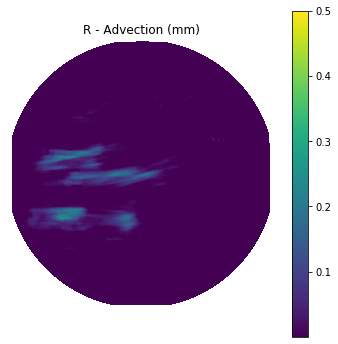

In [8]:
# Accumulate values with 300 seconds 
accum = 300. * accum / (3600. * len(weight))
result = np.sum(accum, axis=0)

def plotting(data, title=None, colorbar=True,*args, **kwargs):
    fig = plt.figure(figsize=(6,6))
    plt.imshow(data, *args, **kwargs)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    if colorbar:
        plt.colorbar()
    return fig

# Add borders that has been eliminated in the data
result[np.mean(R, axis=0) == 0] = 0

fig = plotting(result, title='R - Advection (mm)', vmax=0.5)

Well, just for correct the borders you can storaged a matrix with NaN values.

For comparison, we calculate rain accumulation just using the mean between frame to frame.

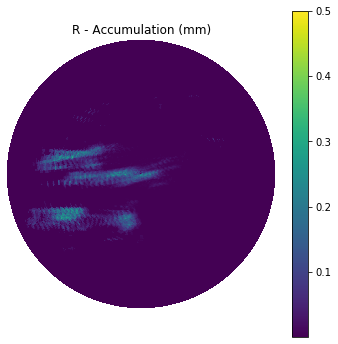

In [10]:
media = np.zeros_like(R)
for i in range(samples - 1):
    media[i, ...] = 0.5 * (R[i, ...] + R[i+1, ...])
    
depths = 300. * media / 3600.
result2 = np.sum(depths, axis=0)
fig = plotting(result2, title='R - Accumulation (mm)', vmax=0.5)